In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qml.kernels import gaussian_kernel
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gpytorch
import torch

In [2]:
def check_duplicate(array):
    """
    Check if any two elements in an array are equal.
    Used in the check_shuffles() function to make sure all the shuffles are distinct.

    Parameters:
        array: A list or array of numpy ndarrays.

    Returns:
        True if any two elements in the array are equal, False otherwise.
    """
    seen = set()
    for element in array:
        temp_element = tuple(element.flatten())
        if temp_element in seen:
            return True
        seen.add(temp_element)
    return False
def check_shuffles():
    """
    Check the shuffles used for a given dataset to ensure they are distinct.
    
    Returns:
        True if no duplicate shuffles are found, False otherwise.
    """
    for i in range(3):
        if check_duplicate(shuffles_output_dummy[i])== True:
            return False
    if check_duplicate(shuffles_x_dummy)==True:
        return False
    return True

In [3]:
np.random.seed(27)
torch.set_default_dtype(torch.float64)

def f1(x):
    return np.sin(x[:, 0]) + np.cos(x[:, 1]) + np.exp(x[:, 2]) + np.sin(x[:, 3]) + np.cos(x[:, 4])
def f2(x):
    return np.cos(x[:, 0]) + np.exp(x[:, 1]) + np.sin(x[:, 2]) + np.cos(x[:, 3]) + np.exp(x[:, 4])
def f3(x):
    return np.sin(x[:, 0]) + np.exp(x[:, 1]) + np.cos(x[:, 2]) + np.sin(x[:, 3]) + np.exp(x[:, 4])
# Generate 3000 samples of 5 dimensional input X with random numbers between 0 and 1
X = np.random.rand(3000, 5)

# Generate 3 dimensional output Y using output functions
Y = np.zeros((3000, 3))
Y[:, 0] = f1(X)
Y[:, 1] = f2(X)
Y[:, 2] = f3(X)

def largest_power_of_two(N):
    """
    Find the largest power of two less than or equal to a given integer.
    
    This function takes the training set size N as input and returns the largest power of two less than or equal to N.
    It also returns a list of all powers of two less than or equal to N.
    
    Parameters:
        N (int): A positive integer.
        
    Returns:
        A tuple containing:
            - An integer representing the largest power of two less than or equal to N.
            - A list of all powers of two less than or equal to N.
    """
    n = 0
    while 2**n < N:
        n += 1
    
    powers = []
    for i in range(1,n):
        if 2**i <= N:
            powers.append(2**i)
        else:
            break
    return n - 1,powers

largest_two,train_sizes=largest_power_of_two(len(X))

In [4]:
shuffles_x_dummy = np.load('../Dummy Data/Dummy Shuffles/shuffles_x_dummy.npy')
shuffles_output_dummy=[np.load('../Dummy Data/Dummy Shuffles/shuffles_y1_dummy.npy'),np.load('../Dummy Data/Dummy Shuffles/shuffles_y2_dummy.npy'),np.load('../Dummy Data/Dummy Shuffles/shuffles_y3_dummy.npy')]
if check_shuffles()==False:
    print("Two or more shuffles are identical. Please run setup again to reshuffle")

In [5]:
# define the Gaussian process regression model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [6]:
def first_initialization(i):
    """
    Initializes the Gaussian Process model with the given training data and kernel hyperparameters.

    Args:
        i(int): output component index
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y[:,i], test_size=0.2,shuffle=False)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9))
    train_x = torch.as_tensor(X_train, dtype = torch.float64)
    train_y = torch.as_tensor(y_train, dtype = torch.float64)
    model = ExactGPModel(train_x, train_y, likelihood)
        
    hypers = {
            'likelihood.noise_covar.noise': torch.tensor(10**-9),
            'covar_module.base_kernel.lengthscale': torch.tensor(100),
            'covar_module.outputscale': torch.tensor(1),
        }
    model.initialize(**hypers)

In [7]:
def GPR(train_x,train_y,test_x,test_y):
    """
    Performs Gaussian Process Regression (GPR) and calculates the mean absolute error between 
    predicted and actual values.

    Parameters:
        train_x (numpy array): Input data for training
        train_y (numpy array): Output data for training
        x_test (numpy array): Array of input testing data.
        test_y (numpy array): Array of output testing data.

    Returns:
        The mean absolute error between predicted and actual values.
    """
    train_x = torch.as_tensor(train_x, dtype = torch.float64)
    train_y = torch.as_tensor(train_y, dtype = torch.float64)
    test_x=torch.as_tensor(test_x,dtype=torch.float64)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9))
    model = ExactGPModel(train_x, train_y, likelihood)
    
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(10**-9),
        'covar_module.base_kernel.lengthscale': torch.tensor(100),
        'covar_module.outputscale': torch.tensor(1),
    }
    model.initialize(**hypers)
    model.eval()
    likelihood.eval()
    # Use the model to make predictions on the test_x values
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        
        # Feed the test_x values through the model and likelihood to get predicted distribution over observed values
        observed_pred = likelihood(model(test_x))

    # Extract the mean and variance of the predicted distribution
    
    mean = observed_pred.mean.detach().numpy()
    return np.mean(np.abs(mean - test_y))

In [8]:
def learning_curve(x_train,x_test,y_train,y_test,shuffles_component):
    """
    Calculates the mean absolute errors of different training sizes
    for a given dataset.

    Parameters:
        x_train (numpy array): Input data for training
        x_test (numpy array): Input data for testing.
        y_train (numpy array): Output data for training.
        y_test (numpy array): Output data for testing.
        shuffles_component (list of numpy arrays): A list of shuffled output data arrays for the training set.
    
    Returns:
        mae_list (numpy array): An array of mean absolute errors for each training size in the learning curve.
    """
    
    mae_list=np.zeros(largest_two,dtype=float)
    for j in range(10):
        X_train1,y_train1=shuffles_x_dummy[j],shuffles_component[j]
        maes=[]

        for i in (2**p for p in range(1,largest_two+1)):
                temp_mae=GPR(X_train1[0:i],y_train1[0:i],x_test,y_test)

                maes.append(temp_mae)
        mae_list[:]=np.copy(maes)
    mae_list=mae_list/10
    return mae_list

In [9]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, shuffle=False, train_size=0.8)

def lc_plots():
    '''
    Plots the learning curves for the transition dipole moment components of a given dataset.
    '''
    lc_results=[]
    for i in range (3):
        shuffles_component=shuffles_output_dummy[i]
        y_train1_temp=y_train1[:,i]
        y_test1_temp=y_test1[:,i]
        temp_result=learning_curve(X_train1,X_test1,y_train1_temp,y_test1_temp,shuffles_component)    
        lc_results.append(temp_result)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Learning Curves for the output components', fontsize=16)
    for i, ax in enumerate(axs):
        ax.loglog(train_sizes, lc_results[i], marker='.', markersize=10, linewidth=2, color='tab:cyan')
        ax.set_xlabel('Number of Training Samples', fontsize=14)
        ax.set_ylabel('Mean Absolute Error', fontsize=14)
        ax.set_title(f'Component {chr(88+i)}', fontsize=16)

    plt.show()

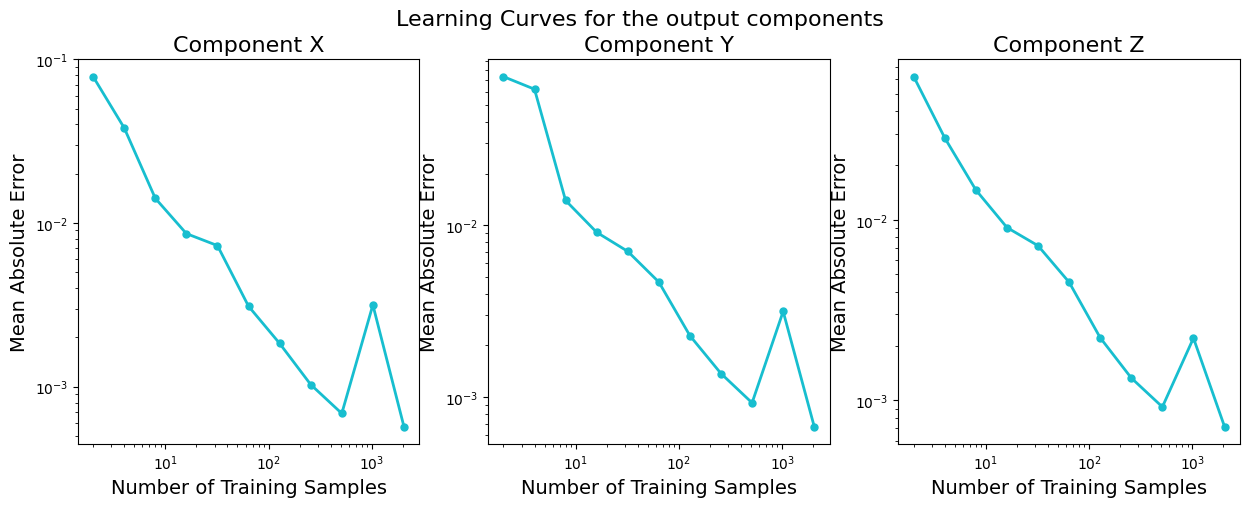

In [10]:
lc_plots()

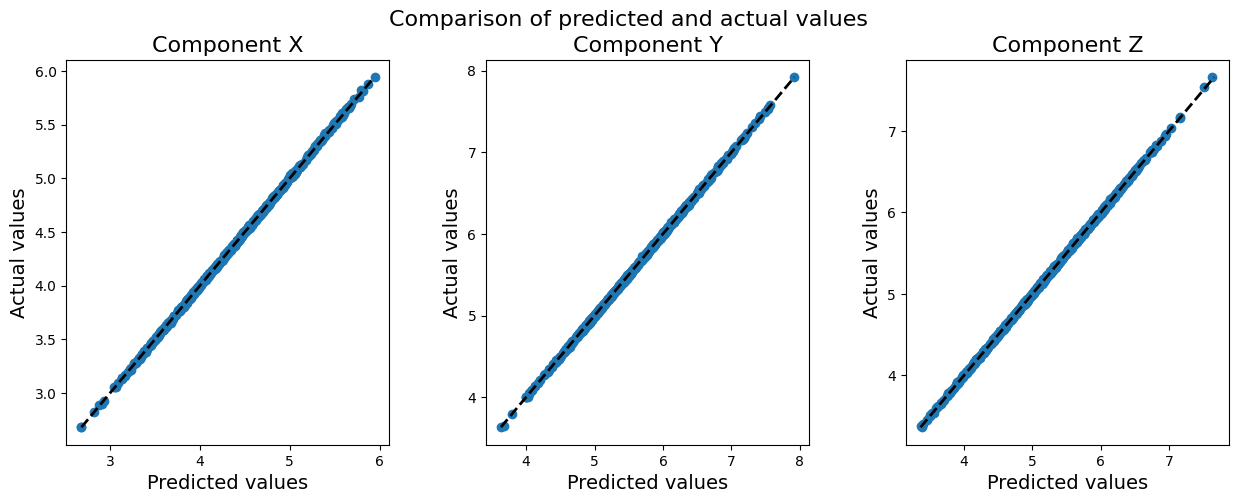

In [11]:
def GPR_predictions(train_x,train_y,test_x,test_y):
    """
    Gaussian Process Regression.

    Parameters:
        train_x (numpy array): Input data for training
        train_y (numpy array): Output data for training, corresponding to an array of scalar values.
        test_x (numpy array): Input data for testing
        test_y (numpy array): Output data for testing, corresponding to an array of scalar values.
    Returns:
        mean(numpy array): The values predicted for the given testing data.
    """
    train_x = torch.as_tensor(train_x, dtype = torch.float64)
    train_y = torch.as_tensor(train_y, dtype = torch.float64)
    test_x=torch.as_tensor(test_x,dtype=torch.float64)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9))
    model = ExactGPModel(train_x, train_y, likelihood)
    
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(10**-9),
        'covar_module.base_kernel.lengthscale': torch.tensor(100),
        'covar_module.outputscale': torch.tensor(1),
    }
    model.initialize(**hypers)
    model.eval()
    likelihood.eval()
    # Use the model to make predictions on the test_x values
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        
        # Feed the test_x values through the model and likelihood to get predicted distribution over observed values
        observed_pred = likelihood(model(test_x))
    
    mean = observed_pred.mean.detach().numpy()
    return mean

predicted_values_results=[]
# Plots the scatter plots for all 3 components
for i in range (3):
    sigma=100
    y_train1_temp=y_train1[:,i]
    y_test1_temp=y_test1[:,i]
    y_predicted_values=GPR_predictions(X_train1,y_train1_temp,X_test1,y_test1_temp)
    predicted_values_results.append(y_predicted_values)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Comparison of predicted and actual values', fontsize=16)
for i, ax in enumerate(axs):
    ax.plot([y_test1[:,i].min(), y_test1[:,i].max()], [y_test1[:,i].min(), y_test1[:,i].max()], 'k--', lw=2)
    ax.scatter(predicted_values_results[i],y_test1[:,i])
    ax.set_xlabel('Predicted values', fontsize=14)
    ax.set_ylabel('Actual values', fontsize=14)
    ax.set_title(f'Component {chr(88+i)}', fontsize=16)
plt.subplots_adjust(wspace=0.3)
plt.show()
